In [1]:
import sys
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd

In [ ]:
# df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/NonPromoterSequence.txt', sep = '>', )
# df.dropna(subset=['Unnamed: 0'], how='all', inplace=True)
# df.reset_index(inplace = True)
# df.drop(['EP 1 (+) mt:CoI_1; range -400 to -100.', 'index'], axis = 1, inplace=True) #data cleaning after error found
# df.rename(columns={'Unnamed: 0': "sequence"}, inplace = True)
# df['label'] = 0

# df2 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/PromoterSequence.txt', sep = '>', )
# df2.dropna(subset=['Unnamed: 0'], how='all', inplace=True)
# df2.reset_index(inplace = True)
# df2.drop(['EP 1 (+) mt:CoI_1; range -100 to 200.', 'index'], axis = 1, inplace=True)
# df2.rename(columns={'Unnamed: 0': "sequence"}, inplace = True)
# df2['label'] = 1

# df = pd.concat([df, df2], axis = 0 )

In [ ]:
# for seq in df['sequence']:
#     if 'N' in seq:
#         display(df.loc[df['sequence'] == seq])

# df.drop([1822], inplace = True)

In [ ]:

# sequence = list(df.loc[:, 'sequence'])
# encoded_seq = []

# def seq2kmer(seq, k):
#     """
#     Convert original sequence to kmers
    
#     Arguments:
#     seq -- str, original sequence.
#     k -- int, kmer of length k specified.
    
#     Returns:
#     kmers -- str, kmers separated by space
#     """
#     kmer = [seq[x:x+k] for x in range(len(seq)+1-k)]
#     kmers = " ".join(kmer)
#     return kmers

# for seq in sequence:
#   x = seq2kmer(seq, 6)
#   encoded_seq.append(x)

# print(encoded_seq[0])


In [ ]:
# label = list(df.loc[:,'label'])
# new_df = pd.DataFrame(encoded_seq, columns = ['sequence'])

# new_df.insert(1, 'label', label)

# new_df.head()

In [ ]:
# new_df.to_csv("dnabert_input.csv", mode='a', header=False)

In [3]:
!pip install transformers

import numpy as np
import os

import joblib
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import utils
import torch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 36.6 MB/s 
     |████████████████████████████████| 7.6 MB 50.9 MB/s 
     |████████████████████████████████| 182 kB 82.3 MB/s 


In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dnabert_input.csv', sep = ',', )
df.columns = ['id', 'sequence', 'label']
df.drop(columns = ['id'])


,sequence,label
0,ATTTTT TTTTTA TTTTAC TTTACA TTACAA TACAAG ACAA...,0
1,AGAGAT GAGATA AGATAG GATAGG ATAGGT TAGGTG AGGT...,0
2,TATGTA ATGTAT TGTATA GTATAT TATATA ATATAG TATA...,0
3,AGAAAT GAAATA AAATAA AATAAT ATAATA TAATAG AATA...,0
4,CTTTAA TTTAAA TTAAAA TAAAAT AAAATT AAATTA AATT...,0
...,...,...
22592,CGACAA GACAAA ACAAAG CAAAGT AAAGTT AAGTTT AGTT...,1
22593,CATATC ATATCT TATCTA ATCTAC TCTACA CTACAT TACA...,1
22594,ATACCG TACCGC ACCGCG CCGCGG CGCGGA GCGGAA CGGA...,1
22595,ATTATT TTATTC TATTCC ATTCCG TTCCGA TCCGAA CCGA...,1


In [5]:
df.shape

(22597, 3)

In [6]:
# Import the necessary 
!pip install --upgrade transformers

import transformers
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
tokenizer = AutoTokenizer.from_pretrained("armheb/DNA_bert_6")

# Load your dataset

data = df

# data['sequence'] = input_sequences

# data.tail()

# Divide the dataset into train, validation, and test sets
train_data, val_data = train_test_split(
    data, 
    test_size=0.1, 
    random_state=42,
    stratify=data['label']
)
val_data, test_data = train_test_split(
    val_data, 
    test_size=0.5, 
    random_state=42,
    stratify=val_data['label']
)

device = torch.device('cuda')
use_cuda = True

train_input = tokenizer.batch_encode_plus(train_data["sequence"].tolist(), 
                                          add_special_tokens=True, 
                                          max_length=512, 
                                          pad_to_max_length=True, 
                                          return_attention_mask=True, 
                                          return_tensors = 'pt')

val_input = tokenizer.batch_encode_plus(val_data["sequence"].tolist(),
                                        add_special_tokens=True, 
                                        max_length=512, 
                                        pad_to_max_length=True, 
                                        return_attention_mask=True, 
                                        return_tensors = 'pt')

test_input = tokenizer.batch_encode_plus(test_data["sequence"].tolist(),
                                         add_special_tokens=True, 
                                         max_length=512, 
                                         pad_to_max_length=True, 
                                         return_attention_mask=True, 
                                         return_tensors = 'pt')

train_input_ids = train_input['input_ids']
train_att_masks = train_input['attention_mask']
train_labels = torch.tensor(train_data['label'].values)

val_input_ids = val_input['input_ids']
val_att_masks = val_input['attention_mask']
val_labels = torch.tensor(val_data['label'].values)

test_input_ids = test_input['input_ids']
test_att_masks = test_input['attention_mask']
test_labels = torch.tensor(test_data['label'].values)

Downloading:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [8]:
class DNABERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 # 기존 -> num_classes = 2
                 num_classes = 2, # softmax 사용(다중분류)
                 dr_rate=None,
                 params=None):
        super().__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier1 = nn.Linear(hidden_size, 256)
        self.relu = nn.ReLU()
        self.classifier2 = nn.Linear(256, num_classes)
        
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def forward(self, token_ids, attention_mask):
        _, pooler = self.bert(input_ids = token_ids,
                              attention_mask = attention_mask,
                              return_dict=False)
        x = self.classifier1(pooler)
        x = self.relu(x)
        return self.classifier2(x)

In [9]:
bert = AutoModel.from_pretrained("armheb/DNA_bert_6")

model = DNABERTClassifier(bert)

if use_cuda and torch.cuda.is_available():
    model.cuda()

# Define the optimizer, loss function, and number of training epochs
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum') 


Downloading:   0%|          | 0.00/359M [00:00<?, ?B/s]

Some weights of the model checkpoint at armheb/DNA_bert_6 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# function to calculate loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [11]:
loss_history = {"train": [], "val":[]}
batch_history = {'loss': [], 'accuracy': []}
accuracy_history = {"train": [], "val":[]}

train_input_size = len(train_input_ids)
val_input_size = len(val_input_ids)
epochs = 5              # (5, 16) need 3 hour in Colab Free
batch_size = 16         #if your gpu big enough, use 32

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    # Set the model to training mode
    model.train()

    epoch_loss = 0.0
    epoch_metric = 0.0

    # Loop over each batch of training data
    for i in tqdm(range(0, train_input_size, batch_size)):
        # Get the current batch of data
        batch_input_ids = train_input_ids[i:i+batch_size].to(device)
        batch_labels = train_labels[i:i+batch_size].to(device)
        batch_att_masks = train_att_masks[i:i+batch_size].to(device)
        # Forward pass
        outputs = model(batch_input_ids, batch_att_masks)

        # Compute the loss
        loss_b, metric_b = loss_batch(loss_fn, outputs, batch_labels, optimizer)

        epoch_loss += loss_b
        if metric_b is not None:
            epoch_metric += metric_b

        if i % 400 == 0:
            print(f'batch {i / batch_size}, loss : {(loss_b/ batch_size):.4f}, accuracy : {(metric_b / batch_size):.4f}')
            batch_history['loss'].append(loss_b / batch_size)
            batch_history['accuracy'].append(metric_b / batch_size)

    epoch_loss = epoch_loss / train_input_size
    epoch_metric = epoch_metric / train_input_size

    loss_history['train'].append(epoch_loss)
    accuracy_history['train'].append(epoch_metric)
    # Set the model to evaluation mode
    model.eval()

    # Evaluate the model on the validation set
    with torch.no_grad():
        val_loss = 0.0
        val_metric = 0.0
        for i in tqdm(range(0, val_input_size, batch_size)):
            # Forward pass
            batch_input_ids = val_input_ids[i:i+batch_size].to(device)
            batch_labels = val_labels[i:i+batch_size].to(device)
            batch_att_masks = val_att_masks[i:i+batch_size].to(device)
            outputs = model(batch_input_ids, batch_att_masks)

            # Compute the loss
            loss_b, metric_b = loss_batch(loss_fn, outputs, batch_labels)
            val_loss += loss_b
            if metric_b is not None:
                val_metric += metric_b

        val_loss = val_loss / val_input_size
        val_metric = val_metric / val_input_size
        loss_history['val'].append(val_loss)
        accuracy_history['val'].append(val_metric)
        # Print the validation loss
    
        print(f'train loss {epoch_loss:.4f}, validation loss {val_loss:.4f}')
        print(f'train accuracy {epoch_metric:.4f}, validation accuracy {val_metric:.4f}')
        print('-'*30)

# Save the finetuned model
# torch.save(model.state_dict(), 'finetuned_model.pth')

Epoch 1/5


  0%|          | 1/1272 [00:04<1:25:33,  4.04s/it]

batch 0.0, loss : 0.6884, accuracy : 0.5625


  2%|▏         | 26/1272 [00:39<29:48,  1.44s/it]

batch 25.0, loss : 0.6547, accuracy : 0.6875


  4%|▍         | 51/1272 [01:15<29:00,  1.43s/it]

batch 50.0, loss : 0.6269, accuracy : 0.6875


  6%|▌         | 76/1272 [01:50<27:58,  1.40s/it]

batch 75.0, loss : 0.6060, accuracy : 0.6250


  8%|▊         | 101/1272 [02:25<27:49,  1.43s/it]

batch 100.0, loss : 0.5035, accuracy : 0.8125


 10%|▉         | 126/1272 [03:01<26:59,  1.41s/it]

batch 125.0, loss : 0.5244, accuracy : 0.7500


 12%|█▏        | 151/1272 [03:36<26:29,  1.42s/it]

batch 150.0, loss : 0.4726, accuracy : 0.7500


 14%|█▍        | 176/1272 [04:12<26:16,  1.44s/it]

batch 175.0, loss : 0.3911, accuracy : 0.8750


 16%|█▌        | 201/1272 [04:47<25:18,  1.42s/it]

batch 200.0, loss : 0.4919, accuracy : 0.8125


 18%|█▊        | 226/1272 [05:23<24:46,  1.42s/it]

batch 225.0, loss : 0.7121, accuracy : 0.7500


 20%|█▉        | 251/1272 [05:58<24:06,  1.42s/it]

batch 250.0, loss : 0.5544, accuracy : 0.7500


 22%|██▏       | 276/1272 [06:34<23:37,  1.42s/it]

batch 275.0, loss : 0.8704, accuracy : 0.5000


 24%|██▎       | 301/1272 [07:09<22:51,  1.41s/it]

batch 300.0, loss : 0.7648, accuracy : 0.5625


 26%|██▌       | 326/1272 [07:44<22:23,  1.42s/it]

batch 325.0, loss : 0.3835, accuracy : 0.8125


 28%|██▊       | 351/1272 [08:20<21:45,  1.42s/it]

batch 350.0, loss : 0.3920, accuracy : 0.7500


 30%|██▉       | 376/1272 [08:55<21:08,  1.42s/it]

batch 375.0, loss : 0.4075, accuracy : 0.7500


 32%|███▏      | 401/1272 [09:31<20:34,  1.42s/it]

batch 400.0, loss : 0.3707, accuracy : 0.8125


 33%|███▎      | 426/1272 [10:06<19:57,  1.41s/it]

batch 425.0, loss : 0.3241, accuracy : 0.8750


 35%|███▌      | 451/1272 [10:42<19:24,  1.42s/it]

batch 450.0, loss : 0.2561, accuracy : 0.8750


 37%|███▋      | 476/1272 [11:17<18:45,  1.41s/it]

batch 475.0, loss : 0.5588, accuracy : 0.7500


 39%|███▉      | 501/1272 [11:52<18:16,  1.42s/it]

batch 500.0, loss : 0.4140, accuracy : 0.8750


 41%|████▏     | 526/1272 [12:28<17:31,  1.41s/it]

batch 525.0, loss : 0.3410, accuracy : 0.8750


 43%|████▎     | 551/1272 [13:03<17:06,  1.42s/it]

batch 550.0, loss : 0.3988, accuracy : 0.8125


 45%|████▌     | 576/1272 [13:39<16:21,  1.41s/it]

batch 575.0, loss : 0.5513, accuracy : 0.7500


 47%|████▋     | 601/1272 [14:14<15:54,  1.42s/it]

batch 600.0, loss : 0.3346, accuracy : 0.7500


 49%|████▉     | 626/1272 [14:50<15:13,  1.41s/it]

batch 625.0, loss : 0.4177, accuracy : 0.8125


 51%|█████     | 651/1272 [15:25<14:40,  1.42s/it]

batch 650.0, loss : 0.4838, accuracy : 0.7500


 53%|█████▎    | 676/1272 [16:00<14:07,  1.42s/it]

batch 675.0, loss : 0.3952, accuracy : 0.9375


 55%|█████▌    | 701/1272 [16:36<13:25,  1.41s/it]

batch 700.0, loss : 0.1658, accuracy : 1.0000


 57%|█████▋    | 726/1272 [17:11<12:54,  1.42s/it]

batch 725.0, loss : 0.3917, accuracy : 0.8125


 59%|█████▉    | 751/1272 [17:47<12:18,  1.42s/it]

batch 750.0, loss : 0.3067, accuracy : 0.8750


 61%|██████    | 776/1272 [18:22<11:41,  1.41s/it]

batch 775.0, loss : 0.4019, accuracy : 0.8750


 63%|██████▎   | 801/1272 [18:57<11:05,  1.41s/it]

batch 800.0, loss : 0.2947, accuracy : 0.9375


 65%|██████▍   | 826/1272 [19:33<10:30,  1.41s/it]

batch 825.0, loss : 0.4363, accuracy : 0.8125


 67%|██████▋   | 851/1272 [20:08<09:54,  1.41s/it]

batch 850.0, loss : 0.3090, accuracy : 0.8750


 69%|██████▉   | 876/1272 [20:43<09:19,  1.41s/it]

batch 875.0, loss : 0.3490, accuracy : 0.8750


 71%|███████   | 901/1272 [21:19<08:45,  1.42s/it]

batch 900.0, loss : 0.4509, accuracy : 0.7500


 73%|███████▎  | 926/1272 [21:54<08:09,  1.42s/it]

batch 925.0, loss : 0.1874, accuracy : 1.0000


 75%|███████▍  | 951/1272 [22:30<07:35,  1.42s/it]

batch 950.0, loss : 0.2228, accuracy : 0.9375


 77%|███████▋  | 976/1272 [23:05<06:59,  1.42s/it]

batch 975.0, loss : 0.1501, accuracy : 0.9375


 79%|███████▊  | 1001/1272 [23:40<06:24,  1.42s/it]

batch 1000.0, loss : 0.1270, accuracy : 0.9375


 81%|████████  | 1026/1272 [24:16<05:49,  1.42s/it]

batch 1025.0, loss : 0.4628, accuracy : 0.7500


 83%|████████▎ | 1051/1272 [24:51<05:13,  1.42s/it]

batch 1050.0, loss : 0.1867, accuracy : 1.0000


 85%|████████▍ | 1076/1272 [25:27<04:37,  1.42s/it]

batch 1075.0, loss : 0.3234, accuracy : 0.8750


 87%|████████▋ | 1101/1272 [26:02<04:01,  1.41s/it]

batch 1100.0, loss : 0.4775, accuracy : 0.7500


 89%|████████▊ | 1126/1272 [26:37<03:26,  1.41s/it]

batch 1125.0, loss : 0.1203, accuracy : 1.0000


 90%|█████████ | 1151/1272 [27:13<02:51,  1.42s/it]

batch 1150.0, loss : 0.4727, accuracy : 0.8750


 92%|█████████▏| 1176/1272 [27:48<02:15,  1.42s/it]

batch 1175.0, loss : 0.1966, accuracy : 0.9375


 94%|█████████▍| 1201/1272 [28:24<01:40,  1.41s/it]

batch 1200.0, loss : 0.1472, accuracy : 0.9375


 96%|█████████▋| 1226/1272 [28:59<01:04,  1.41s/it]

batch 1225.0, loss : 0.3620, accuracy : 0.8125


 98%|█████████▊| 1251/1272 [29:34<00:29,  1.41s/it]

batch 1250.0, loss : 0.2791, accuracy : 0.9375


100%|██████████| 71/71 [00:35<00:00,  1.98it/s]


train loss 0.4031, validation loss 0.2470
train accuracy 0.8126, validation accuracy 0.9018
------------------------------
Epoch 2/5


  0%|          | 1/1272 [00:01<29:55,  1.41s/it]

batch 0.0, loss : 0.1706, accuracy : 0.9375


  2%|▏         | 26/1272 [00:36<29:26,  1.42s/it]

batch 25.0, loss : 0.4700, accuracy : 0.7500


  4%|▍         | 51/1272 [01:12<28:54,  1.42s/it]

batch 50.0, loss : 0.2915, accuracy : 0.8750


  6%|▌         | 76/1272 [01:47<28:16,  1.42s/it]

batch 75.0, loss : 0.2495, accuracy : 0.8125


  8%|▊         | 101/1272 [02:23<27:31,  1.41s/it]

batch 100.0, loss : 0.1470, accuracy : 0.9375


 10%|▉         | 126/1272 [02:58<26:56,  1.41s/it]

batch 125.0, loss : 0.5090, accuracy : 0.7500


 12%|█▏        | 151/1272 [03:33<26:16,  1.41s/it]

batch 150.0, loss : 0.1071, accuracy : 1.0000


 14%|█▍        | 176/1272 [04:08<25:41,  1.41s/it]

batch 175.0, loss : 0.2411, accuracy : 0.9375


 16%|█▌        | 201/1272 [04:44<25:07,  1.41s/it]

batch 200.0, loss : 0.1770, accuracy : 0.8750


 18%|█▊        | 226/1272 [05:19<24:29,  1.41s/it]

batch 225.0, loss : 0.5095, accuracy : 0.6875


 20%|█▉        | 251/1272 [05:54<23:56,  1.41s/it]

batch 250.0, loss : 0.1758, accuracy : 0.9375


 22%|██▏       | 276/1272 [06:29<23:23,  1.41s/it]

batch 275.0, loss : 0.4803, accuracy : 0.8125


 24%|██▎       | 301/1272 [07:04<22:48,  1.41s/it]

batch 300.0, loss : 0.3756, accuracy : 0.8125


 26%|██▌       | 326/1272 [07:39<22:12,  1.41s/it]

batch 325.0, loss : 0.4332, accuracy : 0.8750


 28%|██▊       | 351/1272 [08:15<21:33,  1.40s/it]

batch 350.0, loss : 0.1226, accuracy : 1.0000


 30%|██▉       | 376/1272 [08:50<20:58,  1.41s/it]

batch 375.0, loss : 0.1593, accuracy : 0.9375


 32%|███▏      | 401/1272 [09:25<20:25,  1.41s/it]

batch 400.0, loss : 0.1545, accuracy : 0.9375


 33%|███▎      | 426/1272 [10:00<19:50,  1.41s/it]

batch 425.0, loss : 0.1703, accuracy : 0.9375


 35%|███▌      | 451/1272 [10:35<19:19,  1.41s/it]

batch 450.0, loss : 0.1207, accuracy : 0.9375


 37%|███▋      | 476/1272 [11:11<18:50,  1.42s/it]

batch 475.0, loss : 0.2584, accuracy : 0.8750


 39%|███▉      | 501/1272 [11:46<18:09,  1.41s/it]

batch 500.0, loss : 0.0556, accuracy : 1.0000


 41%|████▏     | 526/1272 [12:21<17:34,  1.41s/it]

batch 525.0, loss : 0.1463, accuracy : 1.0000


 43%|████▎     | 551/1272 [12:57<16:59,  1.41s/it]

batch 550.0, loss : 0.1210, accuracy : 0.9375


 45%|████▌     | 576/1272 [13:32<16:23,  1.41s/it]

batch 575.0, loss : 0.4075, accuracy : 0.8750


 47%|████▋     | 601/1272 [14:07<15:50,  1.42s/it]

batch 600.0, loss : 0.2690, accuracy : 0.8750


 49%|████▉     | 626/1272 [14:43<15:13,  1.41s/it]

batch 625.0, loss : 0.3058, accuracy : 0.8750


 51%|█████     | 651/1272 [15:18<14:39,  1.42s/it]

batch 650.0, loss : 0.2323, accuracy : 0.8750


 53%|█████▎    | 676/1272 [15:53<14:03,  1.42s/it]

batch 675.0, loss : 0.1720, accuracy : 0.8750


 55%|█████▌    | 701/1272 [16:29<13:28,  1.42s/it]

batch 700.0, loss : 0.1319, accuracy : 0.9375


 57%|█████▋    | 726/1272 [17:04<12:52,  1.41s/it]

batch 725.0, loss : 0.3771, accuracy : 0.8750


 59%|█████▉    | 751/1272 [17:40<12:17,  1.42s/it]

batch 750.0, loss : 0.0891, accuracy : 1.0000


 61%|██████    | 776/1272 [18:15<11:41,  1.41s/it]

batch 775.0, loss : 0.3206, accuracy : 0.8750


 63%|██████▎   | 801/1272 [18:50<11:06,  1.41s/it]

batch 800.0, loss : 0.3317, accuracy : 0.8750


 65%|██████▍   | 826/1272 [19:26<10:30,  1.41s/it]

batch 825.0, loss : 0.1267, accuracy : 1.0000


 67%|██████▋   | 851/1272 [20:01<09:55,  1.41s/it]

batch 850.0, loss : 0.2978, accuracy : 0.8750


 69%|██████▉   | 876/1272 [20:36<09:20,  1.42s/it]

batch 875.0, loss : 0.3365, accuracy : 0.9375


 71%|███████   | 901/1272 [21:12<08:44,  1.41s/it]

batch 900.0, loss : 0.2256, accuracy : 0.8750


 73%|███████▎  | 926/1272 [21:47<08:08,  1.41s/it]

batch 925.0, loss : 0.0596, accuracy : 1.0000


 75%|███████▍  | 951/1272 [22:22<07:33,  1.41s/it]

batch 950.0, loss : 0.2452, accuracy : 0.9375


 77%|███████▋  | 976/1272 [22:58<06:58,  1.41s/it]

batch 975.0, loss : 0.0841, accuracy : 1.0000


 79%|███████▊  | 1001/1272 [23:33<06:23,  1.41s/it]

batch 1000.0, loss : 0.0563, accuracy : 1.0000


 81%|████████  | 1026/1272 [24:08<05:48,  1.41s/it]

batch 1025.0, loss : 0.0849, accuracy : 0.9375


 83%|████████▎ | 1051/1272 [24:44<05:12,  1.41s/it]

batch 1050.0, loss : 0.0409, accuracy : 1.0000


 85%|████████▍ | 1076/1272 [25:19<04:37,  1.41s/it]

batch 1075.0, loss : 0.1415, accuracy : 1.0000


 87%|████████▋ | 1101/1272 [25:55<04:01,  1.41s/it]

batch 1100.0, loss : 0.3559, accuracy : 0.9375


 89%|████████▊ | 1126/1272 [26:30<03:26,  1.41s/it]

batch 1125.0, loss : 0.0240, accuracy : 1.0000


 90%|█████████ | 1151/1272 [27:05<02:50,  1.41s/it]

batch 1150.0, loss : 0.3844, accuracy : 0.8750


 92%|█████████▏| 1176/1272 [27:41<02:15,  1.42s/it]

batch 1175.0, loss : 0.1174, accuracy : 0.9375


 94%|█████████▍| 1201/1272 [28:16<01:40,  1.42s/it]

batch 1200.0, loss : 0.1654, accuracy : 0.9375


 96%|█████████▋| 1226/1272 [28:51<01:05,  1.42s/it]

batch 1225.0, loss : 0.2274, accuracy : 0.9375


 98%|█████████▊| 1251/1272 [29:27<00:29,  1.41s/it]

batch 1250.0, loss : 0.2024, accuracy : 0.8750


100%|██████████| 71/71 [00:35<00:00,  1.98it/s]


train loss 0.2230, validation loss 0.2856
train accuracy 0.9148, validation accuracy 0.8858
------------------------------
Epoch 3/5


  0%|          | 1/1272 [00:01<30:00,  1.42s/it]

batch 0.0, loss : 0.3058, accuracy : 0.8750


  2%|▏         | 26/1272 [00:36<29:25,  1.42s/it]

batch 25.0, loss : 0.2399, accuracy : 0.8750


  4%|▍         | 51/1272 [01:12<28:48,  1.42s/it]

batch 50.0, loss : 0.1529, accuracy : 0.9375


  6%|▌         | 76/1272 [01:47<28:08,  1.41s/it]

batch 75.0, loss : 0.1740, accuracy : 0.9375


  8%|▊         | 101/1272 [02:22<27:39,  1.42s/it]

batch 100.0, loss : 0.1099, accuracy : 0.9375


 10%|▉         | 126/1272 [02:58<27:04,  1.42s/it]

batch 125.0, loss : 0.3687, accuracy : 0.8750


 12%|█▏        | 151/1272 [03:33<26:27,  1.42s/it]

batch 150.0, loss : 0.1035, accuracy : 1.0000


 14%|█▍        | 176/1272 [04:09<25:53,  1.42s/it]

batch 175.0, loss : 0.2335, accuracy : 0.9375


 16%|█▌        | 201/1272 [04:44<25:18,  1.42s/it]

batch 200.0, loss : 0.1997, accuracy : 0.9375


 18%|█▊        | 226/1272 [05:20<24:38,  1.41s/it]

batch 225.0, loss : 0.3591, accuracy : 0.8125


 20%|█▉        | 251/1272 [05:55<24:04,  1.41s/it]

batch 250.0, loss : 0.0553, accuracy : 1.0000


 22%|██▏       | 276/1272 [06:30<23:27,  1.41s/it]

batch 275.0, loss : 0.0568, accuracy : 1.0000


 24%|██▎       | 301/1272 [07:06<22:52,  1.41s/it]

batch 300.0, loss : 0.2901, accuracy : 0.8750


 26%|██▌       | 326/1272 [07:41<22:17,  1.41s/it]

batch 325.0, loss : 0.4367, accuracy : 0.8750


 28%|██▊       | 351/1272 [08:16<21:43,  1.42s/it]

batch 350.0, loss : 0.1245, accuracy : 0.9375


 30%|██▉       | 376/1272 [08:52<21:08,  1.42s/it]

batch 375.0, loss : 0.1442, accuracy : 0.9375


 32%|███▏      | 401/1272 [09:27<20:34,  1.42s/it]

batch 400.0, loss : 0.0332, accuracy : 1.0000


 33%|███▎      | 426/1272 [10:03<20:01,  1.42s/it]

batch 425.0, loss : 0.0569, accuracy : 1.0000


 35%|███▌      | 451/1272 [10:38<19:25,  1.42s/it]

batch 450.0, loss : 0.0277, accuracy : 1.0000


 37%|███▋      | 476/1272 [11:13<18:47,  1.42s/it]

batch 475.0, loss : 0.0871, accuracy : 1.0000


 39%|███▉      | 501/1272 [11:49<18:10,  1.41s/it]

batch 500.0, loss : 0.0584, accuracy : 1.0000


 41%|████▏     | 526/1272 [12:24<17:34,  1.41s/it]

batch 525.0, loss : 0.0357, accuracy : 1.0000


 43%|████▎     | 551/1272 [13:00<17:02,  1.42s/it]

batch 550.0, loss : 0.1348, accuracy : 0.9375


 45%|████▌     | 576/1272 [13:35<16:26,  1.42s/it]

batch 575.0, loss : 0.2686, accuracy : 0.8750


 47%|████▋     | 601/1272 [14:10<15:52,  1.42s/it]

batch 600.0, loss : 0.1436, accuracy : 0.9375


 49%|████▉     | 626/1272 [14:46<15:16,  1.42s/it]

batch 625.0, loss : 0.1639, accuracy : 0.9375


 51%|█████     | 651/1272 [15:21<14:37,  1.41s/it]

batch 650.0, loss : 0.1099, accuracy : 0.9375


 53%|█████▎    | 676/1272 [15:57<14:02,  1.41s/it]

batch 675.0, loss : 0.1629, accuracy : 0.9375


 55%|█████▌    | 701/1272 [16:32<13:29,  1.42s/it]

batch 700.0, loss : 0.0666, accuracy : 1.0000


 57%|█████▋    | 726/1272 [17:07<12:53,  1.42s/it]

batch 725.0, loss : 0.4096, accuracy : 0.8750


 59%|█████▉    | 751/1272 [17:43<12:18,  1.42s/it]

batch 750.0, loss : 0.1084, accuracy : 0.9375


 61%|██████    | 776/1272 [18:18<11:42,  1.42s/it]

batch 775.0, loss : 0.2693, accuracy : 0.8750


 63%|██████▎   | 801/1272 [18:54<11:06,  1.42s/it]

batch 800.0, loss : 0.0798, accuracy : 1.0000


 65%|██████▍   | 826/1272 [19:29<10:32,  1.42s/it]

batch 825.0, loss : 0.1034, accuracy : 0.9375


 67%|██████▋   | 851/1272 [20:05<09:57,  1.42s/it]

batch 850.0, loss : 0.3089, accuracy : 0.8750


 69%|██████▉   | 876/1272 [20:40<09:21,  1.42s/it]

batch 875.0, loss : 0.2654, accuracy : 0.9375


 71%|███████   | 901/1272 [21:16<08:45,  1.42s/it]

batch 900.0, loss : 0.0346, accuracy : 1.0000


 73%|███████▎  | 926/1272 [21:51<08:10,  1.42s/it]

batch 925.0, loss : 0.0652, accuracy : 1.0000


 75%|███████▍  | 951/1272 [22:26<07:35,  1.42s/it]

batch 950.0, loss : 0.2075, accuracy : 0.9375


 77%|███████▋  | 976/1272 [23:02<06:59,  1.42s/it]

batch 975.0, loss : 0.1219, accuracy : 0.9375


 79%|███████▊  | 1001/1272 [23:37<06:23,  1.41s/it]

batch 1000.0, loss : 0.0645, accuracy : 1.0000


 81%|████████  | 1026/1272 [24:13<05:48,  1.42s/it]

batch 1025.0, loss : 0.0172, accuracy : 1.0000


 83%|████████▎ | 1051/1272 [24:48<05:12,  1.42s/it]

batch 1050.0, loss : 0.0133, accuracy : 1.0000


 85%|████████▍ | 1076/1272 [25:23<04:38,  1.42s/it]

batch 1075.0, loss : 0.0952, accuracy : 1.0000


 87%|████████▋ | 1101/1272 [25:59<04:01,  1.41s/it]

batch 1100.0, loss : 0.3147, accuracy : 0.9375


 89%|████████▊ | 1126/1272 [26:34<03:26,  1.42s/it]

batch 1125.0, loss : 0.0209, accuracy : 1.0000


 90%|█████████ | 1151/1272 [27:10<02:51,  1.42s/it]

batch 1150.0, loss : 0.5102, accuracy : 0.8750


 92%|█████████▏| 1176/1272 [27:45<02:15,  1.42s/it]

batch 1175.0, loss : 0.0611, accuracy : 1.0000


 94%|█████████▍| 1201/1272 [28:20<01:40,  1.42s/it]

batch 1200.0, loss : 0.0254, accuracy : 1.0000


 96%|█████████▋| 1226/1272 [28:56<01:05,  1.42s/it]

batch 1225.0, loss : 0.1083, accuracy : 0.9375


 98%|█████████▊| 1251/1272 [29:31<00:29,  1.42s/it]

batch 1250.0, loss : 0.1262, accuracy : 0.9375


100%|██████████| 71/71 [00:35<00:00,  1.98it/s]


train loss 0.1587, validation loss 0.2324
train accuracy 0.9442, validation accuracy 0.9248
------------------------------
Epoch 4/5


  0%|          | 1/1272 [00:01<29:55,  1.41s/it]

batch 0.0, loss : 0.0874, accuracy : 0.9375


  2%|▏         | 26/1272 [00:36<29:25,  1.42s/it]

batch 25.0, loss : 0.3904, accuracy : 0.8125


  4%|▍         | 51/1272 [01:12<28:50,  1.42s/it]

batch 50.0, loss : 0.1792, accuracy : 0.9375


  6%|▌         | 76/1272 [01:47<28:14,  1.42s/it]

batch 75.0, loss : 0.1896, accuracy : 0.9375


  8%|▊         | 101/1272 [02:23<27:39,  1.42s/it]

batch 100.0, loss : 0.0393, accuracy : 1.0000


 10%|▉         | 126/1272 [02:58<27:04,  1.42s/it]

batch 125.0, loss : 0.1906, accuracy : 0.8750


 12%|█▏        | 151/1272 [03:33<26:26,  1.42s/it]

batch 150.0, loss : 0.0179, accuracy : 1.0000


 14%|█▍        | 176/1272 [04:09<25:49,  1.41s/it]

batch 175.0, loss : 0.1292, accuracy : 0.9375


 16%|█▌        | 201/1272 [04:44<25:13,  1.41s/it]

batch 200.0, loss : 0.1085, accuracy : 1.0000


 18%|█▊        | 226/1272 [05:19<24:38,  1.41s/it]

batch 225.0, loss : 0.0943, accuracy : 0.9375


 20%|█▉        | 251/1272 [05:55<24:07,  1.42s/it]

batch 250.0, loss : 0.0383, accuracy : 1.0000


 22%|██▏       | 276/1272 [06:30<23:27,  1.41s/it]

batch 275.0, loss : 0.0742, accuracy : 1.0000


 24%|██▎       | 301/1272 [07:06<22:53,  1.41s/it]

batch 300.0, loss : 0.1087, accuracy : 1.0000


 26%|██▌       | 326/1272 [07:41<22:20,  1.42s/it]

batch 325.0, loss : 0.1160, accuracy : 0.9375


 28%|██▊       | 351/1272 [08:16<21:48,  1.42s/it]

batch 350.0, loss : 0.0364, accuracy : 1.0000


 30%|██▉       | 376/1272 [08:52<21:12,  1.42s/it]

batch 375.0, loss : 0.1972, accuracy : 0.9375


 32%|███▏      | 401/1272 [09:27<20:34,  1.42s/it]

batch 400.0, loss : 0.0256, accuracy : 1.0000


 33%|███▎      | 426/1272 [10:03<19:57,  1.42s/it]

batch 425.0, loss : 0.0579, accuracy : 1.0000


 35%|███▌      | 451/1272 [10:38<19:25,  1.42s/it]

batch 450.0, loss : 0.0558, accuracy : 0.9375


 37%|███▋      | 476/1272 [11:14<18:45,  1.41s/it]

batch 475.0, loss : 0.1286, accuracy : 0.9375


 39%|███▉      | 501/1272 [11:49<18:11,  1.42s/it]

batch 500.0, loss : 0.0290, accuracy : 1.0000


 41%|████▏     | 526/1272 [12:24<17:36,  1.42s/it]

batch 525.0, loss : 0.0548, accuracy : 1.0000


 43%|████▎     | 551/1272 [13:00<16:59,  1.41s/it]

batch 550.0, loss : 0.0232, accuracy : 1.0000


 45%|████▌     | 576/1272 [13:35<16:26,  1.42s/it]

batch 575.0, loss : 0.0513, accuracy : 1.0000


 47%|████▋     | 601/1272 [14:11<15:52,  1.42s/it]

batch 600.0, loss : 0.0624, accuracy : 0.9375


 49%|████▉     | 626/1272 [14:46<15:16,  1.42s/it]

batch 625.0, loss : 0.3040, accuracy : 0.9375


 51%|█████     | 651/1272 [15:22<14:39,  1.42s/it]

batch 650.0, loss : 0.3412, accuracy : 0.8750


 53%|█████▎    | 676/1272 [15:57<14:02,  1.41s/it]

batch 675.0, loss : 0.0808, accuracy : 1.0000


 55%|█████▌    | 701/1272 [16:32<13:27,  1.41s/it]

batch 700.0, loss : 0.0524, accuracy : 1.0000


 57%|█████▋    | 726/1272 [17:08<12:51,  1.41s/it]

batch 725.0, loss : 0.2225, accuracy : 0.9375


 59%|█████▉    | 751/1272 [17:43<12:17,  1.42s/it]

batch 750.0, loss : 0.0330, accuracy : 1.0000


 61%|██████    | 776/1272 [18:18<11:42,  1.42s/it]

batch 775.0, loss : 0.0625, accuracy : 1.0000


 63%|██████▎   | 801/1272 [18:54<11:07,  1.42s/it]

batch 800.0, loss : 0.0377, accuracy : 1.0000


 65%|██████▍   | 826/1272 [19:29<10:33,  1.42s/it]

batch 825.0, loss : 0.0902, accuracy : 1.0000


 67%|██████▋   | 851/1272 [20:05<09:57,  1.42s/it]

batch 850.0, loss : 0.1757, accuracy : 0.9375


 69%|██████▉   | 876/1272 [20:40<09:22,  1.42s/it]

batch 875.0, loss : 0.1851, accuracy : 0.9375


 71%|███████   | 901/1272 [21:16<08:46,  1.42s/it]

batch 900.0, loss : 0.1203, accuracy : 0.9375


 73%|███████▎  | 926/1272 [21:51<08:10,  1.42s/it]

batch 925.0, loss : 0.0248, accuracy : 1.0000


 75%|███████▍  | 951/1272 [22:26<07:34,  1.41s/it]

batch 950.0, loss : 0.1747, accuracy : 0.9375


 77%|███████▋  | 976/1272 [23:02<06:58,  1.41s/it]

batch 975.0, loss : 0.0906, accuracy : 0.9375


 79%|███████▊  | 1001/1272 [23:37<06:23,  1.41s/it]

batch 1000.0, loss : 0.0264, accuracy : 1.0000


 81%|████████  | 1026/1272 [24:13<05:47,  1.41s/it]

batch 1025.0, loss : 0.0079, accuracy : 1.0000


 83%|████████▎ | 1051/1272 [24:48<05:12,  1.41s/it]

batch 1050.0, loss : 0.0084, accuracy : 1.0000


 85%|████████▍ | 1076/1272 [25:23<04:36,  1.41s/it]

batch 1075.0, loss : 0.0903, accuracy : 0.9375


 87%|████████▋ | 1101/1272 [25:59<04:01,  1.41s/it]

batch 1100.0, loss : 0.3125, accuracy : 0.9375


 89%|████████▊ | 1126/1272 [26:34<03:26,  1.41s/it]

batch 1125.0, loss : 0.0379, accuracy : 1.0000


 90%|█████████ | 1151/1272 [27:09<02:51,  1.42s/it]

batch 1150.0, loss : 0.2836, accuracy : 0.9375


 92%|█████████▏| 1176/1272 [27:45<02:15,  1.41s/it]

batch 1175.0, loss : 0.0777, accuracy : 0.9375


 94%|█████████▍| 1201/1272 [28:20<01:40,  1.41s/it]

batch 1200.0, loss : 0.0530, accuracy : 1.0000


 96%|█████████▋| 1226/1272 [28:55<01:04,  1.41s/it]

batch 1225.0, loss : 0.2673, accuracy : 0.9375


 98%|█████████▊| 1251/1272 [29:31<00:29,  1.41s/it]

batch 1250.0, loss : 0.3471, accuracy : 0.8750


100%|██████████| 71/71 [00:36<00:00,  1.97it/s]


train loss 0.1144, validation loss 0.2441
train accuracy 0.9621, validation accuracy 0.9168
------------------------------
Epoch 5/5


  0%|          | 1/1272 [00:01<29:53,  1.41s/it]

batch 0.0, loss : 0.1162, accuracy : 1.0000


  2%|▏         | 26/1272 [00:36<29:29,  1.42s/it]

batch 25.0, loss : 0.3277, accuracy : 0.9375


  4%|▍         | 51/1272 [01:12<28:53,  1.42s/it]

batch 50.0, loss : 0.0589, accuracy : 1.0000


  6%|▌         | 76/1272 [01:47<28:18,  1.42s/it]

batch 75.0, loss : 0.2820, accuracy : 0.8750


  8%|▊         | 101/1272 [02:23<27:40,  1.42s/it]

batch 100.0, loss : 0.1236, accuracy : 0.9375


 10%|▉         | 126/1272 [02:58<27:02,  1.42s/it]

batch 125.0, loss : 0.1249, accuracy : 0.9375


 12%|█▏        | 151/1272 [03:34<26:29,  1.42s/it]

batch 150.0, loss : 0.0109, accuracy : 1.0000


 14%|█▍        | 176/1272 [04:09<25:50,  1.41s/it]

batch 175.0, loss : 0.0323, accuracy : 1.0000


 16%|█▌        | 201/1272 [04:44<25:14,  1.41s/it]

batch 200.0, loss : 0.2788, accuracy : 0.9375


 18%|█▊        | 226/1272 [05:20<24:42,  1.42s/it]

batch 225.0, loss : 0.0188, accuracy : 1.0000


 20%|█▉        | 251/1272 [05:55<24:03,  1.41s/it]

batch 250.0, loss : 0.1963, accuracy : 0.9375


 22%|██▏       | 276/1272 [06:31<23:29,  1.42s/it]

batch 275.0, loss : 0.0270, accuracy : 1.0000


 24%|██▎       | 301/1272 [07:06<22:52,  1.41s/it]

batch 300.0, loss : 0.0189, accuracy : 1.0000


 26%|██▌       | 326/1272 [07:41<22:16,  1.41s/it]

batch 325.0, loss : 0.0286, accuracy : 1.0000


 28%|██▊       | 351/1272 [08:17<21:42,  1.41s/it]

batch 350.0, loss : 0.0116, accuracy : 1.0000


 30%|██▉       | 376/1272 [08:52<21:08,  1.42s/it]

batch 375.0, loss : 0.1055, accuracy : 0.9375


 32%|███▏      | 401/1272 [09:28<20:34,  1.42s/it]

batch 400.0, loss : 0.0150, accuracy : 1.0000


 33%|███▎      | 426/1272 [10:03<19:58,  1.42s/it]

batch 425.0, loss : 0.0066, accuracy : 1.0000


 35%|███▌      | 451/1272 [10:38<19:24,  1.42s/it]

batch 450.0, loss : 0.0157, accuracy : 1.0000


 37%|███▋      | 476/1272 [11:14<18:49,  1.42s/it]

batch 475.0, loss : 0.0911, accuracy : 0.9375


 39%|███▉      | 501/1272 [11:49<18:12,  1.42s/it]

batch 500.0, loss : 0.0650, accuracy : 0.9375


 41%|████▏     | 526/1272 [12:25<17:35,  1.42s/it]

batch 525.0, loss : 0.0480, accuracy : 1.0000


 43%|████▎     | 551/1272 [13:00<17:01,  1.42s/it]

batch 550.0, loss : 0.0087, accuracy : 1.0000


 45%|████▌     | 576/1272 [13:35<16:26,  1.42s/it]

batch 575.0, loss : 0.0184, accuracy : 1.0000


 47%|████▋     | 601/1272 [14:11<15:52,  1.42s/it]

batch 600.0, loss : 0.0138, accuracy : 1.0000


 49%|████▉     | 626/1272 [14:46<15:15,  1.42s/it]

batch 625.0, loss : 0.0129, accuracy : 1.0000


 51%|█████     | 651/1272 [15:22<14:42,  1.42s/it]

batch 650.0, loss : 0.2396, accuracy : 0.8750


 53%|█████▎    | 676/1272 [15:57<14:07,  1.42s/it]

batch 675.0, loss : 0.0214, accuracy : 1.0000


 55%|█████▌    | 701/1272 [16:33<13:29,  1.42s/it]

batch 700.0, loss : 0.0179, accuracy : 1.0000


 57%|█████▋    | 726/1272 [17:08<12:52,  1.41s/it]

batch 725.0, loss : 0.0131, accuracy : 1.0000


 59%|█████▉    | 751/1272 [17:44<12:16,  1.41s/it]

batch 750.0, loss : 0.0249, accuracy : 1.0000


 61%|██████    | 776/1272 [18:19<11:42,  1.42s/it]

batch 775.0, loss : 0.1107, accuracy : 0.9375


 63%|██████▎   | 801/1272 [18:54<11:07,  1.42s/it]

batch 800.0, loss : 0.0212, accuracy : 1.0000


 65%|██████▍   | 826/1272 [19:30<10:31,  1.42s/it]

batch 825.0, loss : 0.0197, accuracy : 1.0000


 67%|██████▋   | 851/1272 [20:05<09:56,  1.42s/it]

batch 850.0, loss : 0.1114, accuracy : 0.9375


 69%|██████▉   | 876/1272 [20:41<09:21,  1.42s/it]

batch 875.0, loss : 0.0678, accuracy : 0.9375


 71%|███████   | 901/1272 [21:16<08:46,  1.42s/it]

batch 900.0, loss : 0.0083, accuracy : 1.0000


 73%|███████▎  | 926/1272 [21:51<08:09,  1.42s/it]

batch 925.0, loss : 0.0383, accuracy : 1.0000


 75%|███████▍  | 951/1272 [22:27<07:34,  1.42s/it]

batch 950.0, loss : 0.1396, accuracy : 0.9375


 77%|███████▋  | 976/1272 [23:02<06:59,  1.42s/it]

batch 975.0, loss : 0.0049, accuracy : 1.0000


 79%|███████▊  | 1001/1272 [23:38<06:23,  1.42s/it]

batch 1000.0, loss : 0.0184, accuracy : 1.0000


 81%|████████  | 1026/1272 [24:13<05:49,  1.42s/it]

batch 1025.0, loss : 0.0318, accuracy : 1.0000


 83%|████████▎ | 1051/1272 [24:49<05:13,  1.42s/it]

batch 1050.0, loss : 0.1066, accuracy : 0.9375


 85%|████████▍ | 1076/1272 [25:24<04:37,  1.42s/it]

batch 1075.0, loss : 0.3168, accuracy : 0.8750


 87%|████████▋ | 1101/1272 [25:59<04:01,  1.41s/it]

batch 1100.0, loss : 0.3233, accuracy : 0.9375


 89%|████████▊ | 1126/1272 [26:35<03:26,  1.41s/it]

batch 1125.0, loss : 0.0204, accuracy : 1.0000


 90%|█████████ | 1151/1272 [27:10<02:51,  1.42s/it]

batch 1150.0, loss : 0.2856, accuracy : 0.8750


 92%|█████████▏| 1176/1272 [27:45<02:15,  1.42s/it]

batch 1175.0, loss : 0.0093, accuracy : 1.0000


 94%|█████████▍| 1201/1272 [28:21<01:40,  1.42s/it]

batch 1200.0, loss : 0.0113, accuracy : 1.0000


 96%|█████████▋| 1226/1272 [28:56<01:05,  1.42s/it]

batch 1225.0, loss : 0.1905, accuracy : 0.9375


 98%|█████████▊| 1251/1272 [29:32<00:29,  1.42s/it]

batch 1250.0, loss : 0.0209, accuracy : 1.0000


100%|██████████| 71/71 [00:36<00:00,  1.97it/s]

train loss 0.0855, validation loss 0.2921
train accuracy 0.9721, validation accuracy 0.9159
------------------------------


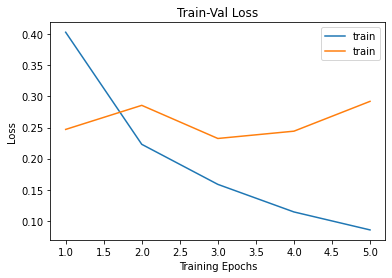

In [13]:
from torchvision import utils
import matplotlib.pyplot as plt

plt.title("Train-Val Loss")
plt.plot(range(1,epochs+1),loss_history["train"], label='train')
plt.plot(range(1,epochs+1),loss_history["val"], label='train')
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


In [14]:
print(batch_history)
print(loss_history)
print(accuracy_history)

{'loss': [0.6884258985519409, 0.6546820998191833, 0.6269376873970032, 0.6060439944267273, 0.5034688115119934, 0.5243822932243347, 0.472578227519989, 0.3910863697528839, 0.49192702770233154, 0.7121032476425171, 0.5543994903564453, 0.870424747467041, 0.7647582292556763, 0.38346031308174133, 0.3919869363307953, 0.4074748456478119, 0.3707006573677063, 0.32409751415252686, 0.2560514211654663, 0.5588202476501465, 0.4140010476112366, 0.3409668505191803, 0.39878392219543457, 0.5512862205505371, 0.3346155881881714, 0.41770026087760925, 0.4837723970413208, 0.3951779901981354, 0.16584107279777527, 0.39169541001319885, 0.30670279264450073, 0.4019317626953125, 0.29468753933906555, 0.4362565875053406, 0.30896610021591187, 0.34896472096443176, 0.4508809745311737, 0.18736684322357178, 0.22280782461166382, 0.15011195838451385, 0.12695127725601196, 0.4628085196018219, 0.1867404580116272, 0.323428213596344, 0.477477490901947, 0.12033864855766296, 0.4726996123790741, 0.1966070830821991, 0.1472003161907196

In [15]:
torch.save(model.state_dict(), 'finetuned_model.pth')